Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Cytochrome P450 (CYP) enzymes are membrane-bound hemeproteins that play a key role in metabolism of drugs and xenobiotics. Assaying the effect of chemicals on CYP isozymes is useful to minimize the adverse drug reactions and toxicities in drug development process. Chemical compounds were tested for their effect on CYP enzyme activities by using P450-Glo (TM) screening systems (Promega Corporation, Madison, WI). These systems provide a luminescent method containing proluciferin substrates and are converted to luciferin products by CYP isozymes. The luciferin products formed are detected with a luciferin detection reagent, and the amount of light produced is proportional to CYP activity. P450-Glo (TM) CYP2D6 screening system (Catalog. No. V9890) was used to detect the compounds that interfere in CYP2D6 activity. The positive control compound used for CYP2D6 assay is quinidine (Sigma-Aldrich, St. Louis, MO).

## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to PUBCHEM_ACTIVITY_SCORE. For all inactive compounds, PUBCHEM_ACTIVITY_SCORE is 0. For all active compounds, a score range was given for each curve class type given above. Active antagonist compounds have PUBCHEM_ACTIVITY_SCORE between 40 and 100. Inconclusive compounds had PUBCHEM_ACTIVITY_SCORE between 1 and 39, and were removed in processing. 
- **PUBCHEM_ACTIVITY_SCORE**: Average of 5 experimental replicates. Fit_LogAC50 was used for determining relative score and was scaled to each curve class' score range.

## Data resource

**Raw data**: 
- CYP2D6: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840
- CYP3A4: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841
- CYP2C9: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[3]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [2]:
org = "polaris"
data_name = "ncats_adme/CYP"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

All datasets were downloaded directly from Pubchem on 2024-03-21 by following the PubChem Bioassay links on https://opendata.ncats.nih.gov/adme/data. \
The same set of molecules were testes for CYPs assays, therefore we merge those three datasets into one. 

In [3]:
aids = ["AID_1645840", "AID_1645841", "AID_1645842"]
names = ["CYP2D6", "CYP3A4", "CYP2C9"]
sources = [
    "https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840",
    "https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841",
    "https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842",
]
mol_col = "SMILES"
datasets = []
mol_id_cols = ["PUBCHEM_SID", "PUBCHEM_CID", mol_col]
data_cols = []
# Looking at the files previously (not shown) indicates metadata rows are 0-4
meta_start = 0  # Start row index
meta_end = 5  # End row index + 1
merged_data = pd.DataFrame(columns=mol_id_cols)
for name, aid in zip(names, aids):
    # Load the dataset
    data = pd.read_parquet(f"{gcp_root}/data/raw/ADME_NCATS/{aid}_raw.parquet")
    # Remove the metadata rows
    data = data.drop(labels=list(range(meta_start, meta_end)), axis=0).reset_index(
        drop=True
    )
    print(f"{name} initial dataset size: {len(data)}")
    # Remap the outcome to binary
    data["PUBCHEM_ACTIVITY_OUTCOME"] = data["PUBCHEM_ACTIVITY_OUTCOME"].map(
        {"Active": 1.0, "Inactive": 0.0}
    )  # Inconclusive compounds will be converted to nan and removed
    # Rename the smiles column
    data.rename(
        columns={
            "PUBCHEM_EXT_DATASOURCE_SMILES": "SMILES",
            "PUBCHEM_ACTIVITY_OUTCOME": f"{name}_OUTCOME",
            "PUBCHEM_ACTIVITY_SCORE": f"{name}_SCORE",
        },
        inplace=True,
    )

    # Define data column names
    endpoints = [
        f"{name}_OUTCOME",
        f"{name}_SCORE",
    ]
    data_cols.extend(endpoints)

    # Narrow the dataframe to just the data_cols and mol_col
    data = data[mol_id_cols + endpoints]
    # Drop any nans
    data.dropna(axis=0, ignore_index=True, inplace=True)
    # data.fillna(-1000, inplace=True)
    data["PUBCHEM_SID"] = data["PUBCHEM_SID"].astype(str)
    data["PUBCHEM_CID"] = data["PUBCHEM_CID"].astype(str)
    merged_data = pd.concat([merged_data, data[mol_id_cols]])
    print(f"{name} data before curation, after dropping nans: {len(data)}")

    # Store the curated dataset in the list
    datasets.append(data)

CYP2D6 initial dataset size: 5242
CYP2D6 data before curation, after dropping nans: 4276
CYP3A4 initial dataset size: 5242
CYP3A4 data before curation, after dropping nans: 4346
CYP2C9 initial dataset size: 5242
CYP2C9 data before curation, after dropping nans: 4461


Because these data are similar/linked and there is overlap between the molecules from the different datasets, we could also combine the data and upload one dataframe.

In [4]:
merged_data = merged_data.drop_duplicates(subset=mol_id_cols, ignore_index=True)
merged_data.shape

(5199, 3)

Fill up the matrix with `CYP2D6`, `CYP3A4`, `CYP2C9` values.

In [5]:
for data in datasets:
    merged_data = merged_data.merge(right=data, on=mol_id_cols, how="outer")
    print(merged_data.shape)

(5199, 5)
(5199, 7)
(5199, 9)


In [6]:
data = merged_data.copy()

In [7]:
source_data_path = f"{gcp_root}/data/raw/CYP.parquet"
data.to_parquet(source_data_path, index=False)

### Run preliminary curation for data inspection

In [8]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import MoleculeCuration, OutlierDetection, Discretization, Deduplication, StereoIsomerACDetection, ContinuousDistributionVisualization

# Define the curation workflow
curator = Curator(
    data_path=source_data_path, 
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols = data_cols),
        ContinuousDistributionVisualization(y_cols=[col for col in data_cols if 'OUTCOME' in col], bins=[0.5]),
        ContinuousDistributionVisualization(y_cols=[col for col in data_cols if 'SCORE' in col], bins=[0]),
        OutlierDetection(method="zscore", columns=[col for col in data_cols if 'SCORE' in col], threshold = 3, use_modified_zscore=True),
        StereoIsomerACDetection(y_cols=[col for col in data_cols if 'OUTCOME' in col])
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

curator.to_json(f"{dirname}/inspection_config.json")

In [9]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-06-04 00:58:24.526 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-06-04 00:58:48.515 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-04 00:58:48.826 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-04 00:58:49.139 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-06-04 00:58:49.353 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [12]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-06-04 00:58:24
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 1001.
[IMG]: Dimensions 2400 x 1800
[IMG]: Dimensions 1200 x 2400
===== distribution =====
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
===== distribution =====
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
===== outlier

In [13]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

### Data Distribution

<img src="inspection_report/images/5-Data_distribution_CYP2D6_SCORE.png" width=300 height=150>

<img src="inspection_report/images/6-Data_distribution_CYP3A4_SCORE.png" width=300 height=150>

<img src="inspection_report/images/7-Data_distribution_CYP2C9_SCORE.png" width=300 height=150>

For each dataset, there is an approximately 50-50 split between active and inactive samples. This is not realistic in a drug discovery program but may still be useful in training models.

### Check activity shift between stereoisomers

Few activity shifts were detected in the dataset.
Let's check those isomers. 

In [20]:
# CYP2D6
data_inspection.iloc[[317 ,11 ,4114 ,2773 ,3933 ,2666 ,4199 ,3816 ,276 ,882],:]

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,MOL_smiles,...,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_CYP2D6_SCORE,OUTLIER_CYP3A4_SCORE,OUTLIER_CYP2C9_SCORE,AC_CYP2D6_OUTCOME,AC_CYP3A4_OUTCOME,AC_CYP2C9_OUTCOME
317,170464631.0,6010.0,C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H...,0.0,0.0,0.0,0.0,0.0,0.0,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...,...,0,6,False,False,False,False,False,True,False,True
11,124890308.0,25762893.0,C[C@]12CCC(=O)C=C1CC[C@H]3[C@@H]2CC[C@]4([C@@H...,1.0,40.0,0.0,0.0,1.0,40.0,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@H]3CC[C@](C)(O)[...,...,0,6,False,False,False,False,False,True,False,True
4114,440681558.0,25262792.0,C[C@H]1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C...,1.0,41.0,NaN,NaN,1.0,42.0,CNC(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C)nc(N4CCO...,...,0,2,False,False,False,False,False,True,False,False
2773,363677525.0,25262792.0,C[C@H]1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C...,0.0,0.0,NaN,NaN,1.0,42.0,CNC(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C)nc(N4CCO...,...,0,2,False,False,False,False,False,True,False,False
3933,440681328.0,57519550.0,CC1C(=N)N(C2=CN=C(N=C2N1CCC(C)C)NC3=CC(=C(C(=C...,1.0,41.0,1.0,44.0,1.0,86.0,CC(C)CCN1c2nc(Nc3cc(F)c(O)c(F)c3)ncc2N(C)C(=N)C1C,...,1,1,True,False,False,False,False,True,False,False
2666,363677195.0,57519550.0,CC1C(=N)N(C2=CN=C(N=C2N1CCC(C)C)NC3=CC(=C(C(=C...,0.0,0.0,1.0,43.0,1.0,43.0,CC(C)CCN1c2nc(Nc3cc(F)c(O)c(F)c3)ncc2N(C)C(=N)C1C,...,1,1,True,False,False,False,False,True,False,False
4199,440681667.0,16720766.0,C1CC2=CC=CC=C2[C@H]1NC3=C4C=CN(C4=NC=N3)[C@@H]...,1.0,43.0,0.0,0.0,1.0,41.0,NS(=O)(=O)OC[C@@H]1C[C@@H](n2ccc3c(N[C@H]4CCc5...,...,0,4,False,False,False,False,False,True,False,False
3816,404904707.0,16720766.0,C1CC2=CC=CC=C2[C@H]1NC3=C4C=CN(C4=NC=N3)[C@@H]...,0.0,0.0,0.0,0.0,NaN,NaN,NS(=O)(=O)OC[C@@H]1C[C@@H](n2ccc3c(N[C@H]4CCc5...,...,0,4,False,False,False,False,False,True,False,False
276,144214009.0,4004.0,CCOC(=O)CC(C(=O)OCC)SP(=S)(OC)OC,1.0,40.0,1.0,84.0,1.0,88.0,CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC,...,1,1,True,False,False,False,False,True,False,False
882,170465311.0,4004.0,CCOC(=O)CC(C(=O)OCC)SP(=S)(OC)OC,0.0,0.0,1.0,42.0,1.0,85.0,CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC,...,1,1,True,False,False,False,False,True,False,False


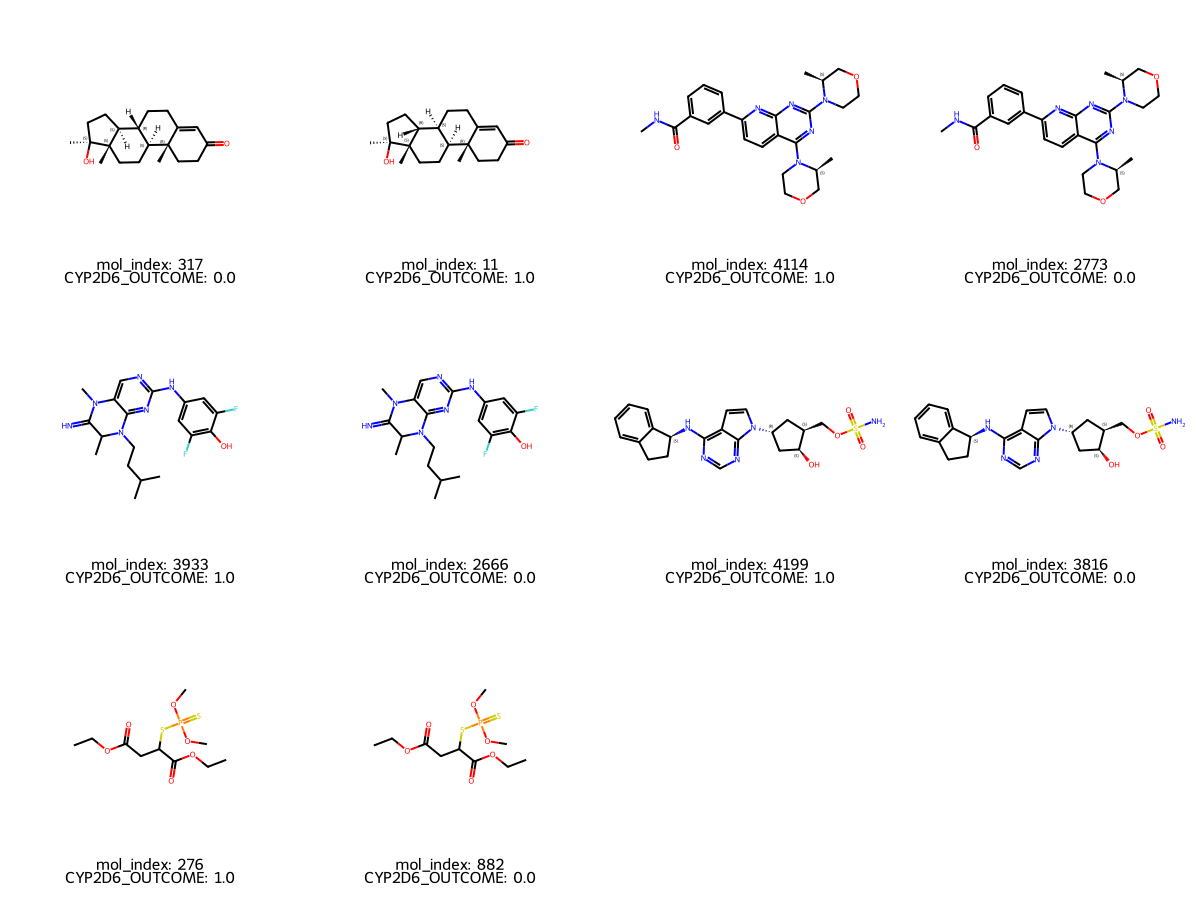

The stereoisomers `CID:25762893` and `CID:6010` are active and inactive in CYP2D6 bioassay. The stereochemical differences are the hydrgens highligted in smiles k'C[C@]12CCC(=O)C=C1CC **[C@H]3** [C@@H]2CC[C@]4( **[C@@H]3** CC[C@]4(C)O)C', 'C[C@]12CCC(=O)C=C1CC **[C@@H]3** [C@@H]2CC[C@]4( **[C@H]3** CC[C@]4(C)O)C'.  \
This indicate the  CYP2D6 activity is sensitive to stereo chemistry information of molecules. It requires the molecular representations which are capable of capture such information for downstream machine learning modeling.

The rest of molecules of the table, `CID:25262792`, `CID:16720766`, `CID:57519550` and `CID:4004` are the same molecules which might be from different providers. Or such activity difference can be the results from experimental noise.  

The `CYP2D6_OUTCOME` is based on a hard thresholding at 40 on `CYP2D6_SCORE` value. The `CYP2D6_SCORE` of the above active molecules are on the borderline. Without any further of detail of this experiment, we recommand to remove them

In [21]:
mols_to_mask = [25262792, 57519550, 16720766, 4004]
data.loc[data.PUBCHEM_CID.isin(mols_to_mask), "CYP2D6_OUTCOME"] = None

In [24]:
# CYP3A4
data_inspection.iloc[[2661 ,4293 ,1093 ,4290 ,4323 ,811 ,3980 ,1110 ,4344 ,84],:]

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,MOL_smiles,...,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_CYP2D6_SCORE,OUTLIER_CYP3A4_SCORE,OUTLIER_CYP2C9_SCORE,AC_CYP2D6_OUTCOME,AC_CYP3A4_OUTCOME,AC_CYP2C9_OUTCOME
2661,363677084.0,62891.0,C1C[C@H](C(NC1)CC(=O)CN2C=NC3=CC(=C(C=C3C2=O)C...,0.0,0.0,0.0,0.0,0.0,0.0,O=C(CC1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O,...,1,2,False,False,False,False,False,False,True,False
4293,144206292.0,60196305.0,C1C[C@H]([C@@H](NC1)CC(=O)CN2C=NC3=CC(=C(C=C3C...,NaN,NaN,1.0,43.0,NaN,NaN,O=C(C[C@@H]1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O,...,0,2,False,False,False,False,False,False,True,False
1093,170465568.0,7619.0,C1COCCN1SC2=NC3=CC=CC=C3S2,0.0,0.0,0.0,0.0,1.0,41.0,c1ccc2sc(SN3CCOCC3)nc2c1,...,0,0,False,0,False,False,False,False,True,False
4290,144204527.0,7619.0,C1COCCN1SC2=NC3=CC=CC=C3S2,NaN,NaN,1.0,40.0,1.0,42.0,c1ccc2sc(SN3CCOCC3)nc2c1,...,0,0,False,0,False,False,False,False,True,False
4323,144214030.0,4197.0,CC1=C(C=C(C(=O)N1)C#N)C2=CC=NC=C2,NaN,NaN,1.0,40.0,1.0,40.0,Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1,...,0,0,False,0,False,False,False,False,True,False
811,170465221.0,4197.0,CC1=C(C=C(C(=O)N1)C#N)C2=CC=NC=C2,0.0,0.0,0.0,0.0,NaN,NaN,Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1,...,0,0,False,0,False,False,False,False,True,False
3980,440681390.0,135400184.0,CC1=C(C2=C(C=C1)N=C(NC2=O)N)SC3=CC=NC=C3,1.0,42.0,1.0,87.0,NaN,NaN,Cc1ccc2nc(N)[nH]c(=O)c2c1Sc1ccncc1,...,0,0,False,0,False,False,False,False,True,False
1110,170465591.0,135409535.0,CC1=C(C2=C(C=C1)N=C(NC2=O)N)SC3=CC=NC=C3.Cl.Cl,1.0,82.0,0.0,0.0,NaN,NaN,Cc1ccc2nc(N)[nH]c(=O)c2c1Sc1ccncc1,...,0,0,False,0,False,False,False,False,True,False
4344,170464733.0,6540478.0,CC[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)OC(=O...,NaN,NaN,0.0,0.0,1.0,43.0,C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)...,...,0,6,False,False,False,False,False,False,True,False
84,144206364.0,6540478.0,CC[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)OC(=O...,1.0,84.0,1.0,87.0,1.0,88.0,C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)...,...,0,6,False,False,False,False,False,False,True,False


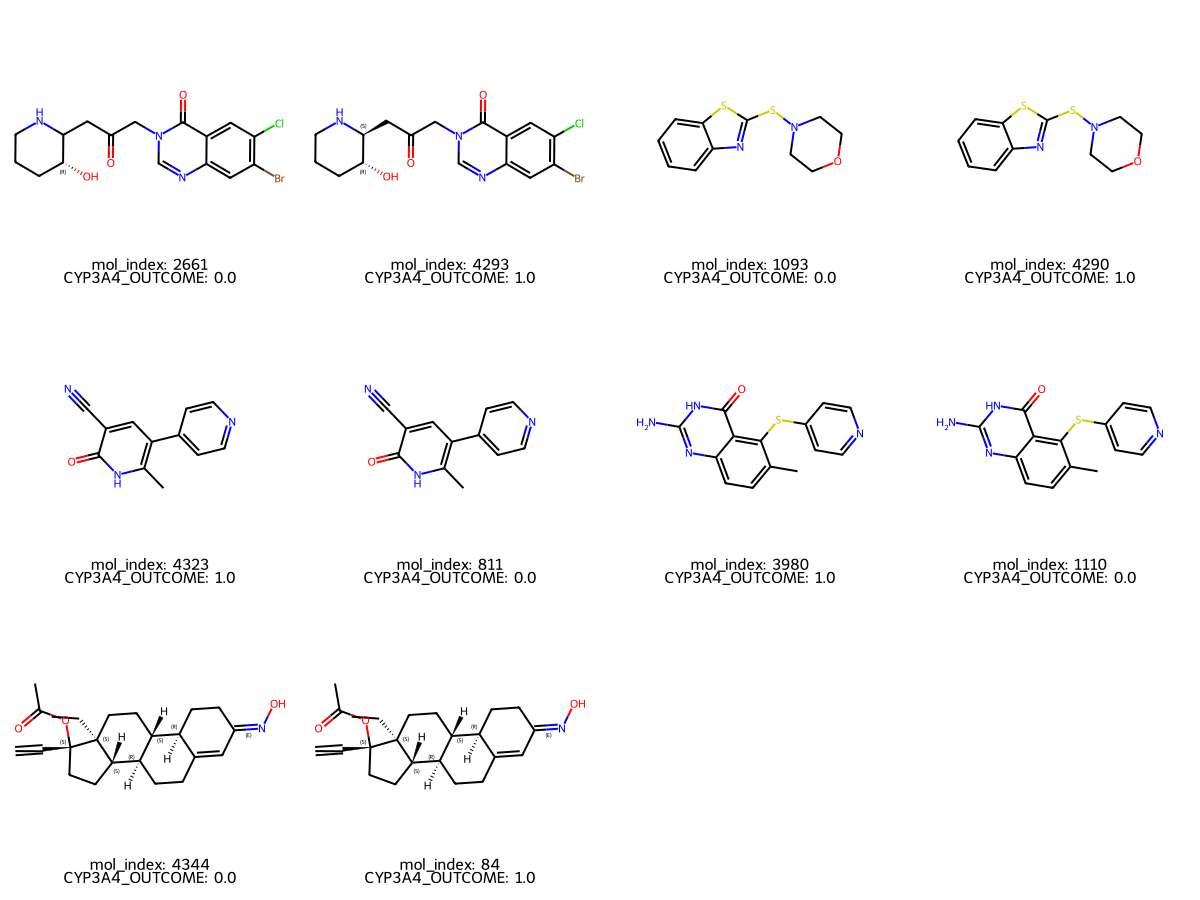

In the case of `CYP3A4`, compound `CID:62891` is not fully annotated with stereochemistry information at the position "O=C(C**C**1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O".  \
It's likely the unspecified molecule is the mixture of both isomers 'O=C(C **[C@@H]** 1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O' and 'O=C(C **[C@H]** 1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O' in the bioassay. However, this cannot be confirmed based on the information available in PubChem bioassay. Therefore, we recommend removing this molecule from the dataset to ensure that downstream modeling is not affected by conflicting values.

For the molecule pair `CID:135409535` and `CID:135400184`. It's hard to judge whether the activity shift is due to the salt (hydrochloric acid), the quality of tested compounds or the experimental error. We would recommand to remove these two molecules from dataset. 

Similarly, the duplicated molecules with conflicting bioactivities should also be removed. 


In [25]:
mols_to_mask = [62891, 7619, 4197, 135409535, 135400184, 6540478]
data.loc[data.PUBCHEM_CID.isin(mols_to_mask), "CYP3A4_OUTCOME"] = None

In [26]:
# CYP2C9
data_inspection.iloc[[4058 ,883 ,3606 ,3252 ,4111 ,954 ,317 ,11 ,4202 ,690 ,592 ,4063 ,4100 ,507 ,4518 ,254 ,5118 ,3640 ,4345 ,2317 ,4588 ,4886 ,2236 ,3580],:]

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,MOL_smiles,...,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_CYP2D6_SCORE,OUTLIER_CYP3A4_SCORE,OUTLIER_CYP2C9_SCORE,AC_CYP2D6_OUTCOME,AC_CYP3A4_OUTCOME,AC_CYP2C9_OUTCOME
4058,440681485.0,54892.0,CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N2C...,0.0,0.0,NaN,NaN,0.0,0.0,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1Cc2c...,...,0,3,False,False,False,False,False,False,False,True
883,170465312.0,54891.0,CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N2C...,0.0,0.0,1.0,83.0,1.0,42.0,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1Cc2c...,...,0,3,False,False,False,False,False,False,False,True
3606,363680752.0,135564570.0,C1COCCN1CC2=CN=C(C=C2)C3=C(NC4=C3C=C(C=C4)C#N)O,1.0,44.0,1.0,84.0,1.0,41.0,N#Cc1ccc2[nH]c(O)c(-c3ccc(CN4CCOCC4)cn3)c2c1,...,0,0,False,0,False,False,False,False,False,True
3252,363680184.0,135564570.0,C1COCCN1CC2=CN=C(C=C2)C3=C(NC4=C3C=C(C=C4)C#N)O,1.0,42.0,1.0,42.0,0.0,0.0,N#Cc1ccc2[nH]c(O)c(-c3ccc(CN4CCOCC4)cn3)c2c1,...,0,0,False,0,False,False,False,False,False,True
4111,440681554.0,5291.0,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,0.0,0.0,1.0,42.0,1.0,40.0,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,...,0,0,False,0,False,False,False,False,False,True
954,170465393.0,123596.0,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,0.0,0.0,NaN,NaN,0.0,0.0,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,...,0,0,False,0,False,False,False,False,False,True
317,170464631.0,6010.0,C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H...,0.0,0.0,0.0,0.0,0.0,0.0,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...,...,0,6,False,False,False,False,False,True,False,True
11,124890308.0,25762893.0,C[C@]12CCC(=O)C=C1CC[C@H]3[C@@H]2CC[C@]4([C@@H...,1.0,40.0,0.0,0.0,1.0,40.0,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@H]3CC[C@](C)(O)[...,...,0,6,False,False,False,False,False,True,False,True
4202,440681670.0,22842821.0,C1CN(C[C@H]1C(C2=CC=CC=C2)(C3=CC=CC=C3)C(=O)N)...,1.0,96.0,NaN,NaN,1.0,41.0,NC(=O)C(c1ccccc1)(c1ccccc1)[C@H]1CCN(CCc2ccc3c...,...,0,1,False,False,False,False,False,False,False,True
690,170465079.0,444030.0,C1CN(C[C@@H]1C(C2=CC=CC=C2)(C3=CC=CC=C3)C(=O)N...,1.0,89.0,0.0,0.0,0.0,0.0,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3...,...,0,1,False,False,False,False,False,False,False,True


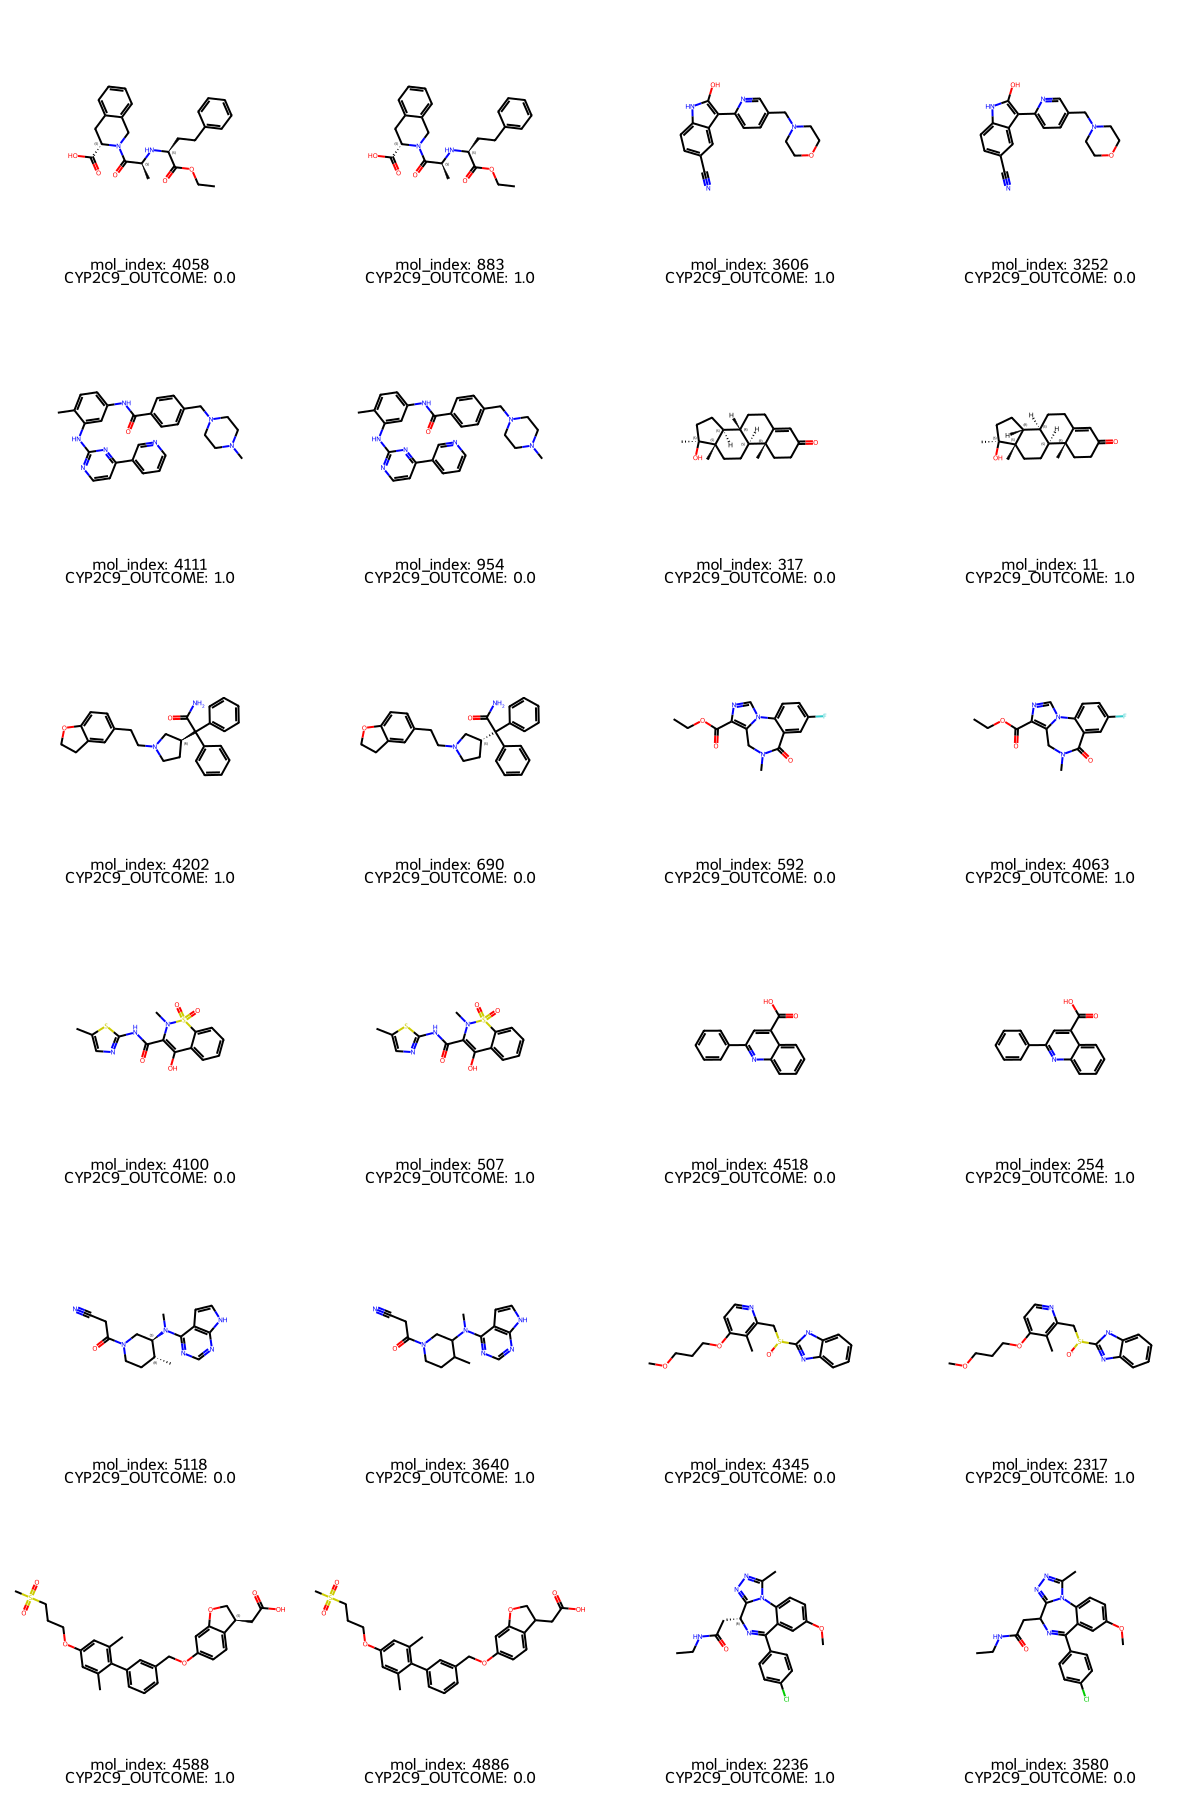

The isomers with opposite activity class `CID:25762893/CID:6010`, `CIDL22842821/CID444030` indicate that `CYP2C9` activity is sensitive to stereochemistry infomration. 
For the similar reason, compound `CID:9818231`, `CID:71460547` and `CID:52934829` are not fully annotated with stereochemistry information. These molecules should be removed from dataset.

In [27]:
mols_to_mask = [
    54891,
    54892,
    135564570,
    123596,
    5291,
    3373,
    54677470,
    8593,
    9818231,
    4659392,
    14720269,
    71460547,
    52934829,
]
data.loc[data.PUBCHEM_CID.isin(mols_to_mask), "CYP2C9_OUTCOME"] = None

### Re-run curation, removing molecules as needed

The above analysis shows the CYP boiactivity can be influenced by stereochemistry information of the molecules. 
We can mask out the molecules with incomplete sterechemistry annotions. 
As usual, the duplicated molecules with conflicting bioactivities should also be removed.

In [28]:
data.reset_index(drop=True, inplace=True)

In [30]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import MoleculeCuration, OutlierDetection, Discretization, Deduplication, StereoIsomerACDetection, ContinuousDistributionVisualization

# Define the curation workflow
curator = Curator(
    data_path=source_data_path, 
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols = data_cols),
        Deduplication(deduplicate_on=mol_col, y_cols=data_cols), # remove the replicated molecules
        ContinuousDistributionVisualization(y_cols=[col for col in data_cols if 'OUTCOME' in col], bins=[0.5]),
        ContinuousDistributionVisualization(y_cols=[col for col in data_cols if 'SCORE' in col], bins=[0]),
        OutlierDetection(method="zscore", columns=[col for col in data_cols if 'SCORE' in col], threshold = 3, use_modified_zscore=True),
        StereoIsomerACDetection(y_cols=[col for col in data_cols if 'OUTCOME' in col])
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

curator.to_json(f"{dirname}/config.json")

In [31]:
# Run the curation step defined as above
data_curated, report = curator(data)

2024-06-04 01:15:28.423 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-06-04 01:15:47.050 | INFO     | auroris.curation._curator:transform:106 - Performing step: deduplicate
2024-06-04 01:15:50.363 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-04 01:15:50.684 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-06-04 01:15:51.118 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-06-04 01:15:51.320 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer
/Users/lu.zhu/Documents/Codebase/ValenceLab/auroris/auroris/curation/actions/_outlier.py:130: RuntimeWarning: divide by zero encountered in divide
  mod_zscore = deviation_from_med / (consistency_correction * mad)
/Users/lu.zhu/Documents/Codebase/ValenceLab/auroris/auroris/curation/actions/_outlier.py:130: RuntimeWarning: invalid value e

In [32]:
broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-06-04 01:15:28
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 1001.
[IMG]: Dimensions 2400 x 1800
[IMG]: Dimensions 1200 x 2400
===== deduplicate =====
[LOG]: Deduplication merged and removed 143 duplicated molecules from dataset
===== distribution =====
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
===== distribution ====

In [33]:
# Export report to polaris public directory on GCP
# The report is ready to reviewed in the HTML file.
broadcaster = HTMLBroadcaster(report, f"{gcp_root}/data/curation/report", embed_images=True)
broadcaster.broadcast()

'gs://polaris-public/polaris-recipes/org-polaris/ncats_adme/CYP/data/curation/report/index.html'

## Export the final curated data

In [37]:
fout = f"{gcp_root}/data/curation/CYP_curated.csv"
data_curated.reset_index(drop=True).to_csv(fout, index=False)

In [38]:
fout

'gs://polaris-public/polaris-recipes/org-polaris/ncats_adme/CYP/data/curation/CYP_curated.csv'

In [36]:
# upload to Polaris Hub
# dataset.upload_to_hub(owner=owner, access="private")